In [18]:
import cv2
import numpy as np
import _pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


Let us first read the train and test files

In [19]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))


In [20]:
train_images_filenames[12]

'../../Databases/MIT_split/train/Opencountry/fie26.jpg'

We create a SIFT object detector and descriptor

In [21]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [22]:

Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)


We now compute a k-means clustering on the descriptor space

In [23]:
k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=2560, compute_labels=False, n_clusters=128,
                random_state=42, reassignment_ratio=0.0001, verbose=False)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [24]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

We build a k-nn classifier and train it with the train descriptors

In [25]:
knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knn.fit(visual_words, train_labels) 

KNeighborsClassifier(metric='euclidean', n_jobs=-1)

We end up computing the test descriptors and compute the accuracy of the model

In [26]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [27]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)

53.53159851301115


Dimensionality reduction, with PCA and LDA

In [28]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

54.39900867410161


In [29]:
lda = LinearDiscriminantAnalysis()
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)

59.727385377943


Now we repeat the previous steps, but in this case we compute the keypoints with DENSE method, by default we initialize
the keypoint detector with 20 pixels width. The key points are separated by 20 pixels and we compute the keypoints with 5
different scales.

After this, we will compare the accuracy between SIFT keypoints and DENSE keypoints.

In [14]:
%reset -f
import cv2
import numpy as np
import _pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

class DenseDetector():
    def __init__(self, step_size=20, feature_scale=20, img_bound=20):
        # Create a dense feature detector
        self.initXyStep = step_size
        self.initFeatureScale = feature_scale
        self.initImgBound = img_bound

    def detect(self, img):
        keypoints = []
        rows, cols = img.shape[:2]
        for x in range(self.initImgBound, rows, self.initFeatureScale):
            for y in range(self.initImgBound, cols, self.initFeatureScale):
                keypoints.append(cv2.KeyPoint(float(x), float(y), self.initXyStep))
        return keypoints

SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)

Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt = DenseDetector(10, 10, 5).detect(gray)
    kpt,des=SIFTdetector.compute(gray,kpt)

    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)


knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knn.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    kpt = DenseDetector(10, 10, 5).detect(gray)
    kpt,des=SIFTdetector.compute(gray,kpt)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)


pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels)
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

lda = LinearDiscriminantAnalysis()
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels)
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)

74.72118959107806
74.96902106567535
79.5539033457249


We can see that the accuracy is more better with DENSE keypoints that SIFT keypoints. The main difference is that with DENSE
method, we compute a descriptors with a fixed with and the descriptors fit the image size.


In [16]:
%reset -f
import cv2
import numpy as np
import _pickle as cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

features = np.arange(50,600,50)
iteration_accuracy = []
for nfeatures in features:
    SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures= int(nfeatures))

    Train_descriptors = []
    Train_label_per_descriptor = []

    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)

        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)

    D=np.vstack(Train_descriptors)

    k = 128
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)

    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)


    knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knn.fit(visual_words, train_labels)

    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
        words=codebook.predict(des)
        visual_words_test[i,:]=np.bincount(words,minlength=k)

    accuracy = 100*knn.score(visual_words_test, test_labels)



    pca = PCA(n_components=64)
    VWpca = pca.fit_transform(visual_words)
    knnpca = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knnpca.fit(VWpca, train_labels)
    vwtestpca = pca.transform(visual_words_test)
    accuracy = 100*knnpca.score(vwtestpca, test_labels)


    lda = LinearDiscriminantAnalysis()
    VWlda = lda.fit_transform(visual_words,train_labels)
    knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
    knnlda.fit(VWlda, train_labels)
    vwtestlda = lda.transform(visual_words_test)
    accuracy = 100*knnlda.score(vwtestlda, test_labels)
    iteration_accuracy.append(accuracy)

Now, we test the process with different amount of features to compare the performance.

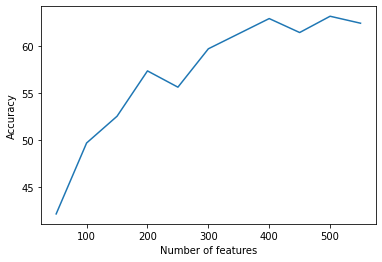

In [17]:
import matplotlib.pyplot as plt

plt.plot(features,iteration_accuracy)
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.show()

We can see that if we increment the amount of features, the performance is better, but the computational time it's to longer,
because the computer needs more memory to store all the descriptors values.